# This notebook contains the code for our detection models

## Install and Import

In [ ]:
import pandas as pd
import numpy as np
from wordcloud import WordCloud
import matplotlib.pyplot as plt
from tqdm import tqdm

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import warnings
warnings.filterwarnings('ignore')

## Read Data
**This section is only run once. Jump to "read from csv"**

In [ ]:
raw = pd.read_csv('/content/drive/MyDrive/Harvard/AC297R/data/training_samples_short2.csv')

In [ ]:
raw.head()

,id,response_txt,question,ethnicity,temperature,max_length,label,model,Unnamed: 8,perplexity,augmented_response_txt,name,perplexity_aug
0,2,These were videos of racial violence that were...,VEM_14,Middle Eastern or North African,NaN,NaN,0,NaN,NaN,3.715902,These were videos of racial violence that were...,NaN,3.715902
1,4,Any discrimination I have ever received due to...,EED_12,Asian,NaN,NaN,0,NaN,15.0,3.160784,Any discrimination I have ever received due to...,NaN,3.072959
2,5,These experiences of discrimination have cause...,MDS_7,Asian,NaN,NaN,0,NaN,NaN,3.892604,These experiences of discrimination have cause...,NaN,3.892604
3,6,The worst experience that stands out to me is ...,RTS_10,Asian,NaN,NaN,0,NaN,NaN,3.044798,The worst experience that stands out to me is ...,NaN,2.969679
4,7,This actually started me on my journey of cont...,RTS_13,Asian,NaN,NaN,0,NaN,NaN,3.491052,This actually started me on my journey of cont...,NaN,3.491052


In [ ]:
(raw.response_txt == raw.augmented_response_txt).sum()

6056

In [ ]:
raw.label.value_counts()

1    6000
0    2999
Name: label, dtype: int64

## Helper Functions

In [ ]:
import torch
from transformers import GPT2LMHeadModel, GPT2TokenizerFast

device = "cuda"
# device = "cpu"
model_id = "gpt2-large"
model_ppl = GPT2LMHeadModel.from_pretrained(model_id).to(device)
tokenizer_ppl = GPT2TokenizerFast.from_pretrained(model_id)

config.json:   0%|          | 0.00/666 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/3.25G [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/124 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/1.04M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

In [ ]:
def calculate_ppl(text):
    encodings = tokenizer_ppl(text, return_tensors="pt")

    max_length = model_ppl.config.n_positions
    stride = 512
    seq_len = encodings.input_ids.size(1)

    nlls = []
    prev_end_loc = 0
    for begin_loc in tqdm(range(0, seq_len, stride)):
        end_loc = min(begin_loc + max_length, seq_len)
        trg_len = end_loc - prev_end_loc  # may be different from stride on last loop
        input_ids = encodings.input_ids[:, begin_loc:end_loc].to(device)
        target_ids = input_ids.clone()
        target_ids[:, :-trg_len] = -100

        with torch.no_grad():
            outputs = model_ppl(input_ids, labels=target_ids)

            # loss is calculated using CrossEntropyLoss which averages over valid labels
            # N.B. the model only calculates loss over trg_len - 1 labels, because it internally shifts the labels
            # to the left by 1.
            neg_log_likelihood = outputs.loss

        nlls.append(neg_log_likelihood)

        prev_end_loc = end_loc
        if end_loc == seq_len:
            break

    ppl = torch.exp(torch.stack(nlls).mean())
    return ppl

In [ ]:
from transformers import pipeline

model_senti = "cardiffnlp/twitter-roberta-base-sentiment-latest"
pipe_senti = pipeline("sentiment-analysis", model=model_senti, tokenizer=model_senti, max_length=512, truncation=True)

config.json:   0%|          | 0.00/929 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/501M [00:00<?, ?B/s]

Some weights of the model checkpoint at cardiffnlp/twitter-roberta-base-sentiment-latest were not used when initializing RobertaForSequenceClassification: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/239 [00:00<?, ?B/s]

In [ ]:
from torch.utils.data import Dataset

class ListDataset(Dataset):
     def __init__(self, original_list):
        self.original_list = original_list
     def __len__(self):
        return len(self.original_list)
     def __getitem__(self, i):
        return self.original_list[i]

In [ ]:
def calculate_sentiment(text_column):
    dataset = ListDataset(text_column)
    sentiments = []
    sentiments_scores = []

    for res in tqdm(pipe_senti(dataset)):
        sentiments.append(res['label'])
        sentiments_scores.append(res['score'])

    return sentiments, sentiments_scores

In [ ]:
import nltk
from collections import Counter
# Download the nltk sentence tokenizer (only need to run this once)
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')
nltk.download('tagsets')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.
[nltk_data] Downloading package tagsets to /root/nltk_data...
[nltk_data]   Unzipping help/tagsets.zip.


True

In [ ]:
def calculate_sent_features(text):
    sentences = nltk.sent_tokenize(text)
    sentence_num = len(sentences)

    tokens = [nltk.word_tokenize(sentence) for sentence in sentences]
    sentence_length = sum(len(sent) for sent in tokens) / len(tokens) if tokens else 0
    return sentence_num, sentence_length

In [ ]:
def calculate_pos(text_column):
    pos = []

    for text in text_column:
        tokens = nltk.word_tokenize(text)
        tags = nltk.pos_tag(tokens)
        counts = Counter(tag for word, tag in tags)
        pos.append(counts)

    return pos

## Augment Dataset

In [ ]:
# perplexity
raw['ppl'] = raw.augmented_response_txt.apply(calculate_ppl)
raw['ppl'] = raw.ppl.apply(lambda x:x.item())

In [ ]:
# sentiment
raw['sentiment'], raw['sentiment_score'] = calculate_sentiment(raw.augmented_response_txt)

100%|██████████| 8999/8999 [54:19<00:00,  2.76it/s]


In [ ]:
# sentence feature
raw['sentence_cnt'], raw['avg_sentence_len'] = zip(*raw.augmented_response_txt.apply(calculate_sent_features))

In [ ]:
# pos
pos_list = calculate_pos(raw.augmented_response_txt)
pos_df = pd.DataFrame(pos_list)
pos_df = pos_df.fillna(0)
raw = pd.concat([raw, pos_df], axis=1)

In [ ]:
raw.groupby('label').mean()

,id,temperature,max_length,Unnamed: 8,perplexity,perplexity_aug,ppl,sentiment_score,sentence_cnt,avg_sentence_len,...,``,:,RBS,FW,PDT,UH,#,$,WP$,SYM
label,,,,,,,,,,,,,,,,,,,,,
0,2119.421807,NaN,NaN,40.0,3.890730,3.87334,72.501779,0.814721,1.988996,20.507251,...,0.025342,0.011671,0.036345,0.005002,0.015672,0.004001,0.000333,0.000333,0.000000,0.000000
1,7398.037000,0.960372,257.439344,NaN,2.187886,2.52202,15.434656,0.828063,7.360000,18.015518,...,0.695833,0.366833,0.041167,0.012833,0.047000,0.019333,0.010833,0.005333,0.000167,0.000333


In [ ]:
raw.to_csv("/content/drive/MyDrive/Harvard/AC297R/data/training_samples_short2_aug.csv", index=False)

### read from csv

In [ ]:
raw = pd.read_csv('/content/drive/MyDrive/Harvard/AC297R/data/training_samples_short2_aug.csv', encoding='utf-8')

In [ ]:
raw[raw.augmented_response_txt.apply(lambda x:len(x.split(' '))<50)].groupby('label').count()

,id,response_txt,question,ethnicity,temperature,max_length,model,Unnamed: 8,perplexity,augmented_response_txt,...,``,:,RBS,FW,PDT,UH,#,$,WP$,SYM
label,,,,,,,,,,,,,,,,,,,,,
0,2493,2493,2493,2479,0,0,0,14,2493,2493,...,2493,2493,2493,2493,2493,2493,2493,2493,2493,2493
1,1177,1177,1177,942,1159,1159,1177,0,1177,1177,...,1177,1177,1177,1177,1177,1177,1177,1177,1177,1177


## Data Processing

In [ ]:
POS = ['DT', 'VBD', 'NNS', 'IN', 'JJ', 'NN', 'WDT',
        'RB', 'VBN', 'NNP', '.', 'PRP', 'VB', 'VBP', 'TO', 'PRP$', 'VBZ', 'VBG',
        'CC', ',', 'JJS', 'RP', 'WRB', 'MD', 'WP', 'POS', '\'\'', 'CD', 'EX',
        'JJR', 'RBR', '(', ')', 'NNPS', '``', ':', 'RBS', 'FW', 'PDT', 'UH',
        '#', '$']

In [ ]:
cont = ['DT', 'VBD', 'NNS', 'IN', 'JJ', 'NN', 'WDT',
        'RB', 'VBN', 'NNP', '.', 'PRP', 'VB', 'VBP', 'TO', 'PRP$', 'VBZ', 'VBG',
        'CC', ',', 'JJS', 'RP', 'WRB', 'MD', 'WP', 'POS', '\'\'', 'CD', 'EX',
        'JJR', 'RBR', '(', ')', 'NNPS', '``', ':', 'RBS', 'FW', 'PDT', 'UH',
        '#', '$', 'ppl', 'sentiment_score', 'sentence_cnt',
        'avg_sentence_len']

In [ ]:
cat = ['sentiment']

In [ ]:
df = pd.concat([raw[cont+['label']], pd.get_dummies(raw[cat], drop_first=True)], axis=1)

In [ ]:
df

,DT,VBD,NNS,IN,JJ,NN,WDT,RB,VBN,NNP,...,UH,#,$,ppl,sentiment_score,sentence_cnt,avg_sentence_len,label,sentiment_neutral,sentiment_positive
0,4.0,3.0,1.0,4.0,1.0,5.0,1.0,3.0,2.0,1.0,...,0.0,0.0,0.0,41.095642,0.928537,2,15.500000,0,0,0
1,6.0,0.0,2.0,6.0,4.0,9.0,0.0,3.0,2.0,0.0,...,0.0,0.0,0.0,21.605749,0.886610,2,28.000000,0,0,0
2,1.0,1.0,2.0,1.0,2.0,4.0,0.0,1.0,1.0,0.0,...,0.0,0.0,0.0,49.038433,0.889697,1,26.000000,0,0,0
3,6.0,1.0,3.0,7.0,1.0,10.0,1.0,3.0,1.0,2.0,...,0.0,0.0,0.0,19.485657,0.921035,3,19.666667,0,0,0
4,5.0,3.0,2.0,5.0,1.0,8.0,0.0,3.0,2.0,0.0,...,0.0,0.0,0.0,32.820461,0.948396,2,22.500000,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8994,1.0,0.0,3.0,5.0,3.0,4.0,0.0,1.0,3.0,1.0,...,0.0,0.0,0.0,57.425915,0.644110,2,19.500000,1,0,0
8995,2.0,3.0,4.0,4.0,4.0,7.0,0.0,1.0,1.0,2.0,...,0.0,0.0,0.0,38.987877,0.943450,5,11.200000,1,0,0
8996,2.0,8.0,1.0,3.0,1.0,4.0,0.0,5.0,4.0,2.0,...,0.0,0.0,0.0,16.491302,0.881228,5,13.400000,1,0,0
8997,2.0,3.0,0.0,2.0,2.0,3.0,0.0,3.0,3.0,0.0,...,0.0,0.0,0.0,20.612080,0.939731,3,10.666667,1,0,0


In [ ]:
df['POS'] = df[POS].sum(axis=1)

In [ ]:
df[POS] = df[POS].div(df.POS, axis=0)

In [ ]:
df.groupby('label').mean()

,DT,VBD,NNS,IN,JJ,NN,WDT,RB,VBN,NNP,...,PDT,UH,#,$,ppl,sentiment_score,sentence_cnt,avg_sentence_len,sentiment_neutral,sentiment_positive
label,,,,,,,,,,,,,,,,,,,,,
0,0.061486,0.066731,0.042084,0.106674,0.069324,0.115729,0.003478,0.066501,0.028285,0.007286,...,0.000371,0.000183,0.000006,0.000007,72.501779,0.814721,1.988996,20.507251,0.106369,0.027009
1,0.055797,0.068782,0.041246,0.095416,0.054240,0.108467,0.001958,0.053255,0.022820,0.013219,...,0.000362,0.000153,0.000110,0.000062,15.434656,0.828063,7.360000,18.015518,0.126167,0.020000


In [ ]:
X, y = df[cont+['sentiment_neutral', 'sentiment_positive']], df['label']

In [ ]:
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, f1_score, recall_score, classification_report, accuracy_score
from sklearn.inspection import permutation_importance

from xgboost import XGBClassifier, plot_importance
from imblearn.over_sampling import SMOTE
from imblearn.ensemble import EasyEnsembleClassifier
# import optuna
import matplotlib.pyplot as plt

In [ ]:
# train test split by 7:3
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=27)

In [ ]:
# fit scaler on the training data for continuous variables
scaler = StandardScaler()
scaler.fit(X_train[cont])

# scale the training and test data for continuous variables
X_train[cont] = scaler.transform(X_train[cont])
X_test[cont] = scaler.transform(X_test[cont])

## Modeling

In [ ]:
model2 = RandomForestClassifier(random_state=27)
model2.fit(X_train, y_train)

RandomForestClassifier(random_state=27)

In [ ]:
y_pred2 = model2.predict(X_test)

In [ ]:
print(classification_report(y_test, y_pred2))

              precision    recall  f1-score   support

           0       0.94      0.90      0.92       887
           1       0.95      0.97      0.96      1813

    accuracy                           0.95      2700
   macro avg       0.95      0.94      0.94      2700
weighted avg       0.95      0.95      0.95      2700



In [ ]:
confusion_matrix(y_test, y_pred2)

array([[ 802,   85],
       [  48, 1765]])

### Feature Importance

In [ ]:
test_result = permutation_importance(
    model2, X_test, y_test, n_repeats=10, random_state=42, n_jobs=2, scoring='accuracy'
)
train_result = permutation_importance(
    model2, X_train, y_train, n_repeats=10, random_state=42, n_jobs=2, scoring='accuracy'
)

In [ ]:
imp_rf_b_p = pd.DataFrame(test_result.importances_mean, index=model2.feature_names_in_, columns=['importance'])
imp_rf_b_p['std'] = test_result.importances_std

In [ ]:
imp_rf_b_p.sort_values('importance', ascending=False, inplace=True)
imp_rf_b_p.head(10)

,importance,std
ppl,0.080926,0.003857
sentence_cnt,0.032185,0.003460
",",0.014778,0.002188
'',0.013963,0.002902
``,0.010148,0.001770
:,0.006370,0.001192
NNP,0.006333,0.001772
RB,0.004630,0.001139
avg_sentence_len,0.004259,0.000781
.,0.002741,0.001162


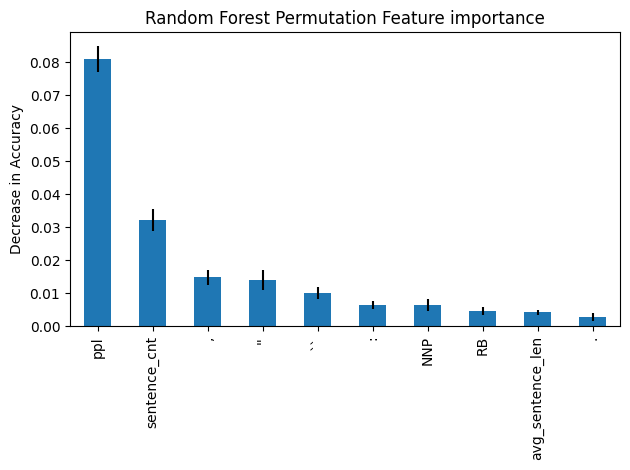

In [ ]:
fig, ax = plt.subplots()
imp_rf_b_p.head(10)['importance'].plot.bar(yerr=imp_rf_b_p.head(10)['std'])
ax.set_title("Random Forest Permutation Feature importance")
ax.set_ylabel("Decrease in Accuracy")
fig.tight_layout()

In [ ]:
imp_rf_b_p_train = pd.DataFrame(train_result.importances_mean, index=model2.feature_names_in_, columns=['importance'])
imp_rf_b_p_train['std'] = train_result.importances_std

In [ ]:
imp_rf_b_p_train.sort_values('importance', ascending=False, inplace=True)
imp_rf_b_p_train.head(10)

,importance,std
ppl,0.084982,0.002404
sentence_cnt,0.037101,0.001462
",",0.015050,0.001863
'',0.010271,0.001138
NNP,0.007271,0.000544
``,0.003953,0.000786
avg_sentence_len,0.002127,0.000258
DT,0.001540,0.000284
:,0.001429,0.000246
IN,0.001143,0.000138


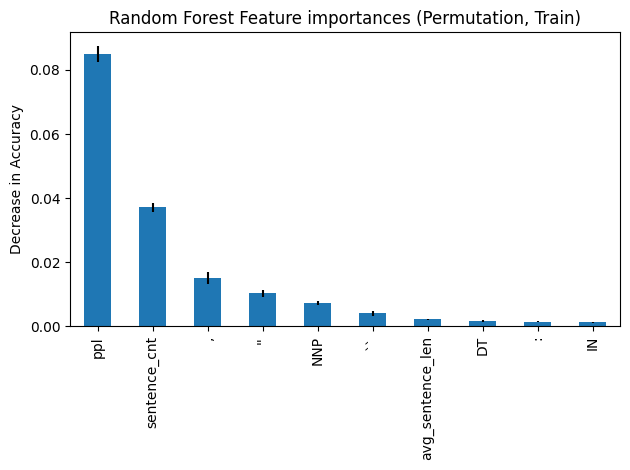

In [ ]:
fig, ax = plt.subplots()
imp_rf_b_p_train.head(10)['importance'].plot.bar(yerr=imp_rf_b_p_train.head(10)['std'])
ax.set_title("Random Forest Feature importances (Permutation, Train)")
ax.set_ylabel("Decrease in Accuracy")
fig.tight_layout()